# Simulating power

How do you determine the sample size necessary to obtain a real effect (with a desired probability)? The typical approach to this is to run a power analysis for known distributions, which analytically calculates how many participants you need to have in order to have an 80% chance, for example, to detect an effect. One tool to accomplish this is called [G-power](http://www.psychologie.hhu.de/arbeitsgruppen/allgemeine-psychologie-und-arbeitspsychologie/gpower.html).

The problems with using G-power and similar analytical tools are that:
- you can only use them for analyses they have implemented that have a simple analytical solution (e.g., t-tests, ANOVA). They do not offer power analyses for mixed-effects regressions and many other tools that you have learned in the class.
- they calculate power only as a function of "number of participants" - they do not take into account the fact that increasing the number of observations per participant can also increase power, by decreasing variability in individual estimates

One solution to these problems is to analyze the power to detect an effect by simulation. The idea is quite simple - you generate artificial data by choosing plausible parameters based on the existing literature (this will be described in more detail below), then you run the analysis of your choice on the simulated data. The proportion of simulations in which you find a statistically significant result is the power of your study, or the probability with which you can expect to find a real effect of that size in your sample.


## Basic algorithm

Simulation power analyses follow these steps, on which we'll expand in the subsequent sections:
1. Determine the sources of variance - between subject variability, trial-by-trial variability, etc.
2. Write a **data simulation** function with the following form:
    - input: parameters that control sample size, number of trials, means and variances of conditions
    - procedure: simulate observations given these parameters
    - output: simulated dataset
3. Write an **analysis** function:
    - input: simulated dataset
    - procedure: run analysis and extract statistical significance
    - output: statistical significance value (p-value, change in AIC or  change in BIC, whether confidence intervals for coefficients overlap with zero, etc.)
4. Write a **for-loop** that:
    - repeatedly runs the prior two functions for different sample sizes and numbers of trials, and extracts parameter estimates and whether the analysis is significant
5. Assess the simulation in terms of three **quality metrics** (see lecture and/or Beaujean reading):
    - Coverage
    - Relative parameter estimate bias
    - Relative standard error bias

### 1) Determine the sources of variance

The outcome of any statistical analysis depends on how much your observations vary as you sample them. Variance comes from many sources -- there are individual differences, noisy sampling, trial-by-trial variability, etc. Which of these variance sources you need to specify depends on the analysis you want to run.

Let's start with a simple example. Say you want to determine whether horses are on average taller than zebras using a t-test. There is a "true" underlying difference in the population (fun fact: horses are taller than zebras). So let's that if you measure the heights of all horses and all zebras you would get the following population parameters:

$$\mu_h = 163 cm$$
$$\mu_z = 135 cm$$

However, because there is variability present within horse and zebra height, if you collect 5 measurements from each group, you would get sample statistics that are similar but not identical to the population parameters. It is even possible that you would, by chance (with such a small sample) get a group of zebras that are on average taller than the group of horses. 

Therefore, in order to run a power analysis for a t-test comparing the height of zebras and horses, you need to specify the expected variability of height for each group. 

Let's say that height is *normally distributed* with the above means ($\mu_h$ and $\mu_z$) and standard deviations of:

$$\sigma_h = 15cm$$
$$\sigma_z = 7cm$$

Or, written more compactly:

$$Height_h \sim \mathcal{N}(\mu_h,\,\sigma_h^{2})$$
$$Height_z \sim \mathcal{N}(\mu_z,\,\sigma_z^{2})$$


### 2) Write a function to simulate artificial data
Now let's write a function to simulate some data consistent with the above parameters.

In [ ]:
# a function for simulating data for two groups. Sample size is the number of people in each group
simulate_data <- function(sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    # draw observation from a normal distribution
    obs_group1 <- rnorm(sample_size, group1_mu, group1_sd)
    obs_group2 <- rnorm(sample_size, group2_mu, group2_sd)
    return(data.frame(group1=obs_group1, group2=obs_group2))
}

With the first function we can simulate the heights for 5 zebras and 5 horses:

In [ ]:
set.seed(040819) # this just helps us get the same "random" result every time we run it - for demo purposes
heights = simulate_data(sample_size = 5, group1_mu = 163, group1_sd = 15, 
                        group2_mu = 135, group2_sd = 7)
print(heights)

    group1   group2
1 161.4690 149.8151
2 147.4244 146.1182
3 178.3596 125.8281
4 141.2860 143.7526
5 154.0626 136.3627


### 3) Write a function to conduct your intended analysis
Now we can write a function to perform the t-test for the two groups. 

In [ ]:
# a function for running a t-test and extracting p-value
run_analysis <- function(data) {
    fit <- t.test(data$group1, data$group2)
    return(c(fit$estimate[1] - fit$estimate[2],fit$stderr,fit$p.value)) # this outputs the effect size, standard error, and significance for quality metrics 
}

With this second function we can run an independent samples `t.test` and extract the `p.value`:

In [ ]:
run_analysis(heights)[3]

0.07431449

Now, this particular sample did not have significantly different heights ($p > 0.05$). However, this may have just been chance - selecting only 5 of each group might actually give us a significant difference *most* of the time, but not this time. If we repeat this process many times for this particular sample size, in what proportion of cases will we find a significant difference? Let's put both previous functions together to simulate the data and calculate the statistical result 1000 times. Note that we can also control our definition of "significant" by specifying an alpha-level for the p-value. 

In [ ]:
# a function for repeatedly running the t-test on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    simouts <- matrix(rep(NA,n_simulations*3),nrow=n_simulations,ncol=3) # empty vector to store ests, stderr, p-values from each simulation
    
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(sample_size, group1_mu, group1_sd, group2_mu, group2_sd) # simulate the data using the defined function
        simouts[i,] <- run_analysis(data) # run the analysis, and add outputs to the matrix
    }
    
    # calculate coverage (AKA power)
    cvg <- mean(simouts[,3] <= alpha) # this is the same as the number of sims that successfully rejected null divided by total number of sims - probability of correctly rejecting the null!
    # calculate relative parameter estimate bias
    theta_bias <- ( mean(simouts[,1]) - (group1_mu-group2_mu) ) / (group1_mu-group2_mu)
    # calculate relative standard error bias 
    sigma_bias <- (mean(simouts[,2]) - sd(simouts[,1])) / sd(simouts[,1])

    return(list(cvg = cvg, theta_bias=theta_bias, sigma_bias=sigma_bias, p.values=simouts[,3])) #return a list with the power as the probability of a sig. result and the corresponding p-values
}


For 1000 simulations of 5 participants per group and an alpha significance level of 0.05, we have a power of:

In [ ]:
set.seed(040819)
results = repeat_analysis(n_simulations = 1000, alpha = 0.05, sample_size = 5,
                          group1_mu=163, group1_sd = 15, group2_mu = 135, group2_sd = 7)
results[1:3]

$cvg
[1] 0.86

$theta_bias
[1] -0.02080461

$sigma_bias
[1] -0.04510002

This means that there is a 86% probability that we correctly reject the null (no difference in heights between horses and zebras) at p < 0.05 if we measure the heights of 5 animals per group. Additionally, we see there's a 2% difference between the original, generative effect size and the mean effect sizes of the simulated fits, and 4.5% difference between the simulated fits' standard errors and the standard deviation of estimates across the fits. 

Try varying the number of simulations in the code above (from 1000 to 10000, for example) and see how that impacts each of the bias terms. You'll notice that `theta_bias` gets smaller, while `sigma_bias` stays about the same. This is because with more simulations the effect size estimate is getting more accurate (Law of Large Numbers), but because there are still very few animals in each sample the effect size estimate still varies a lot from one simulation to the next. Thus, most of the model fits are under-estimating the parameter estimate variance. 


If we measure 10 animals per group instead, we have much greater power to detect an effect:

In [ ]:
set.seed(040819)
results = repeat_analysis(n_simulations = 1000, alpha = 0.05, sample_size = 10,
                          group1_mu=163, group1_sd = 15, group2_mu = 135, group2_sd = 7)
results[1:3]

$cvg
[1] 0.999

$theta_bias
[1] 0.001730866

$sigma_bias
[1] -0.03701442

Now we have 99% chance of correctly rejecting the null, and both of our biases have gotten smaller as well. *Comprehension check: why did `sigma_bias` decrease when we increased the number of animals?*

If we become more conservative with our statistical threshold (by decreasing the alpha value), power decreases, while the biases don't change much:

In [ ]:
set.seed(18546)
results = repeat_analysis(n_simulations = 1000, alpha = 0.001, sample_size = 10,
                          group1_mu=163, group1_sd = 15, group2_mu = 135, group2_sd = 7)
results[1:3]

$cvg
[1] 0.811

$theta_bias
[1] 0.004931981

$sigma_bias
[1] -0.03198967

To make it clearer, we can visualize the distribution of p.values obtained from each simulation:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



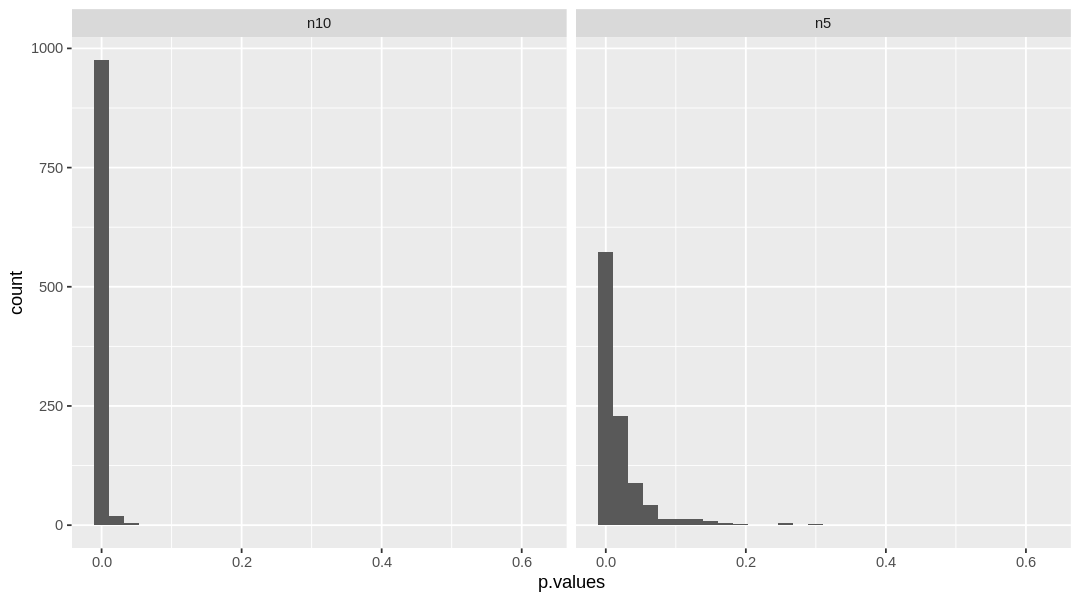

In [ ]:
require(tidyverse)
options(repr.plot.width=9, repr.plot.height=5)

results_n5 = repeat_analysis(1000, 0.05, 5, 163, 15, 135, 7)
results_n10 = repeat_analysis(1000, 0.05, 10, 163, 15, 135, 7)


power_df = data.frame(cbind(n5 = results_n5$p.values, n10 = results_n10$p.values)) %>% 
            gather('n_samples', c('n5', 'n10'), value = 'p.values')


ggplot(power_df, aes(x=p.values)) + geom_histogram() + facet_grid(.~n_samples)

When $n = 10$, nearly all the samples yielded $p$-values below 0.05. The distribution of $p$-values for $n=5$ is wider, with more non-significant values.

### 4) Vary the sample size and alpha levels

Before, we asked what the power was when we varied the number of samples, or the number of people that we collected data from. Now, for the inverse question. How many **animals** do we need to be 95% certain that we will detect the true significant difference in heights between horses and zebras? Yes, you could manually vary the above function's parameters until you obtain a desired level of power, but we can instead simulate data for different sample sizes in an automated way and choose the sample size that gives us the desired power. 

To do this, we can use the `tidyverse` package to create a dataframe with parameters, then simulate data for each row of the dataframe, store the results in a column, then run the analysis on that column and store the resulting p.value. If you need a reminder of the details of tidyverse, revisit the tutorial for "05 - Data as objects and architectures".

In [ ]:
# first, create a data.frame to store the results
dat <- expand.grid(sample_size = 2:20, alpha = c(0.05,0.01,0.001)) #vary the criterion for sig. and the sample size
dat$id <- 1:nrow(dat) #identify each combination of parameters as a separate parameter case for below (otherwise, "unnesting" will be impossible)

# then use tidyverse functions to run the analysis for each sample size
results <- dat  %>%  #using the dataframe defined above
    nest(parameters :=  c(sample_size,alpha)) %>% # separate the parameters into lists split by parameter combo case and call the new column of lists 'parameters' 
    mutate(power = map(parameters, ~ repeat_analysis(1000, .$alpha, .$sample_size, 163, 15, 135, 7)$cvg))  %>%  # note: "map" is like running a for loop, but more efficiently
    #for each case within parameters, repeat the analysis, varying the alpha and sample size
    #store the power associated with all cases as a new variable called power 
    unnest(c(parameters, power)) #return the dataframe to an unnested state, making each element of the list its own row

In [ ]:
head(results) #now for each combination of sample size and alpha we have a power estimate, neatly arranged 

id,sample_size,alpha,power
<int>,<int>,<dbl>,<dbl>
1,2,0.05,0.178
2,3,0.05,0.451
3,4,0.05,0.704
4,5,0.05,0.847
5,6,0.05,0.942
6,7,0.05,0.982


Now we can plot the power level for the different sample sizes and alpha levels:

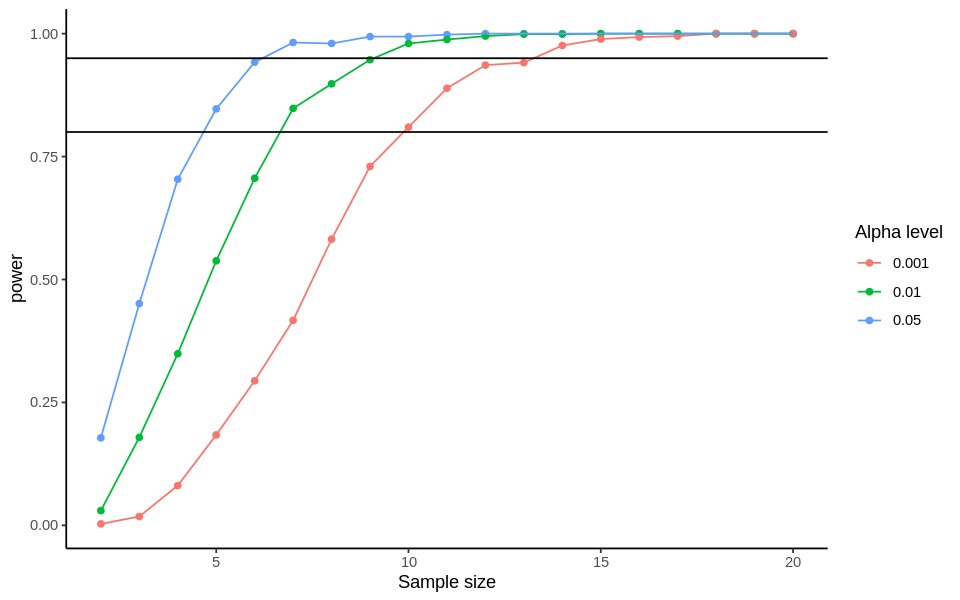

In [ ]:
options(repr.plot.width=8) # resetting size of plot
ggplot(results, aes(sample_size, power, color=as.factor(alpha), group=alpha)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) + # Drew lines at these values because they are
    geom_hline(yintercept = 0.95) + # both traditionally used power thresholds
    scale_color_discrete('Alpha level') +
    scale_x_continuous('Sample size') +
    theme_classic() # this just makes it pretty

You can see that for a power of 95%, you need 13 animals per group to detect a difference in height at the 0.001 threshold for significance.  Progressively fewer animals are needed to reach the same power at less strict alpha thresholds. Now you can see the beauty of using data simulation as a tool for power analyses! 



## Extending to more complicated analyses: Example with mixed-models

The basic procedure outlined above and the functions presented can be extended to any type of analysis in which there is a significance threshold (e.g., alpha). The only thing that has to be changed is the generation of the data and the analysis function. In generating the data, the most complicated thing is specifying the variance structure. 

Let's take for example a mixed-effects regression of reaction times in a priming lexical decision experiment. We are interested in whether people make a lexical decision ("Is this string a word or not?") faster after semantically congruent prime (seeing "red" before "orange") rather than semantically incongruent prime (seeing "rod" before "orange"). 

How do we generate data for this? Typical psycholinguistic experiments use repeated measures designs where each participant performs many trials in each condition. The reaction time to any trial is determined by:

- mean of each condition (expected population priming effect)
- individual differences in overall speed ( $\beta_{subject\_intercept}$ ; different intercepts for each subject)
- individual differences in effect of priming condition ($\beta_{subject\_slope}$ ; some people might show stronger differences between the two conditions than others)
- trial-by-trial variation


So our mixed effects model and data structure would be as follows:

$$RTs = \beta_{subject\_intercept} + \beta_{subject\_slope} * condition + \epsilon_{trial}$$

In the formula above, $\beta_{subject\_intercept}$ and $\beta_{subject\_slope}$ are both vectors, with each value corresponding to an individual subject's average reaction time speed or mean reaction time difference between conditions, respectively. We can reframe each of these terms as the mean value across subjects, plus a noise vector $\epsilon$, centered at 0, which accounts for each individual's deviation from the mean:

$$\beta_{subject\_intercept} = \beta_{overall\_intercept} + \epsilon_{intercept}$$

$$\beta_{subject\_slope} = \beta_{mean\_difference} + \epsilon_{slope}$$

Now, the $\epsilon$ terms are sampled from normal distributions centered at 0:

$$\epsilon_{trial} \sim \mathcal{N}(0, \sigma_{trial}^2)$$

$$\epsilon_{intercept} \sim \mathcal{N}(0, \sigma_{intercept}^2)$$

$$\epsilon_{slope} \sim \mathcal{N}(0, \sigma_{slope}^2)$$

So in our simulation we need to specify 5 parameters for the data generation:
- $\beta_{overall\_intercept}$ (Average RTs for congruent primes)
- $\beta_{mean\_difference}$ (Average RT difference between congruent and incongruent primes)
- $\sigma_{trial}$ (The standard deviation of RTs on each trial, if each participant responds to the same item)
- $\sigma_{intercept}$ (How much individual subjects vary in their overall speed)
- $\sigma_{mean\_difference}$ (How much individual subjects vary in how strongly they are affected by priming)

Let's pick some plausible parameters based on prior literature and educated guessing:

$$\beta_{overall\_intercept} = 700 ms.$$

$$\beta_{mean\_difference} = 50 ms.$$

$$\sigma_{trial} = 200 ms.$$

$$\sigma_{intercept} = 100 ms.$$ 

$$\sigma_{mean\_difference} = 50 ms.$$

*Note: when doing a real power analysis simulation, you may want to identify a plausible range and test a few values within it to make sure these "guesses" don't drastically impact your power analysis.*

How many subjects and trials per subject do we need to achieve 80% power? Let's adapt the functions we wrote above so we can answer these questions. 

*Check out the documentation for [map](https://purrr.tidyverse.org/reference/index.html) and [nest](https://tidyr.tidyverse.org/reference/nest.html) to help understand the code below.*

In [ ]:
install.packages("lme4")
library(lme4) # we need lme4 so we can do test-runs of mixed effects analyses. 
require(tidyverse) # in case tidyverse needs to be re-loaded

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’


Loading required package: Matrix

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



In [ ]:
# a function for simulating data for mixed-model.
simulate_data <- function(n_subjects, n_trials, intercept, 
                          slope, intercept_sd, slope_sd, trial_sd) {
    # draw observation from a normal distribution
    subject_intercepts <- rnorm(n_subjects, intercept, intercept_sd) # sample from a distribution centered at mean subject RT, varying with sd of subject RT
    subject_slopes <- rnorm(n_subjects, slope, slope_sd) # sample from distribution centered at mean effect size, varying with sd of effect size
    dat <- data.frame(subject = 1:n_subjects, intercept = subject_intercepts, slope=subject_slopes)
    # generate trials for each subject
    dat <- dat  %>% 
        nest(., parameters :=  c(intercept, slope))  %>% # for each subject
        # sample n_trials values for two new vars using "intercept" and "slope" values calculated above, adding trial variability using trial_sd
        # congruent just uses intercept for mean (the baseline condition, faster RT), 
        # incongruent uses intercept+slope to account for effect of being slower condition
        mutate(congruent = map(parameters, ~rnorm(n_trials, intercept, trial_sd)),
               incongruent = map(parameters, ~rnorm(n_trials, intercept+slope, trial_sd)))  %>%  # 
        unnest(c(congruent,incongruent), .drop = FALSE)  %>%
        unnest(parameters)  %>% # ungroup the data so it's a normal data frame again
        gather(prime, rt, congruent, incongruent) # puts it in long form - tidy data! 
    return(dat)
}


# a function for running a mixed-model and extracting coverage, theta_bias, sigma_bias, and p-values. 
run_analysis <- function(data) {
    # fit null and alternative model
    m0 <- lmer(rt ~ 1 + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE)) # null model
    m1 <- lmer(rt ~ prime + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE)) # alternative model

    est <- fixef(m1)[2] # estimate of Incongruent - Congruent difference in RT 
    se <- summary(m1)$coef[, 2, drop = FALSE][2] # stderr of estimate
    m_bic <- BIC(m0, m1)$BIC#Outputs Bayesian Information Criterion to assess goodness of model fit
    statistic <- diff(m_bic)#You can replace with change in AIC or a p-value for a likelihood ratio statistic
    return(c(est,se,statistic))
}

Before we run the full analysis, just for demonstration, here is simulated data for some subjects:

In [ ]:
set.seed(04082020)
dat <- simulate_data(10, 10, 700, 50, 100,50,200)
head(dat, n=20)

Warning message:
“The `.drop` argument of `unnest()` is deprecated as of tidyr 1.0.0.
All list-columns are now preserved.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


subject,intercept,slope,prime,rt
<int>,<dbl>,<dbl>,<chr>,<dbl>
1,658.1670,116.9944,congruent,637.7850
1,658.1670,116.9944,congruent,355.5954
1,658.1670,116.9944,congruent,312.3804
1,658.1670,116.9944,congruent,683.2322
1,658.1670,116.9944,congruent,641.0751
1,658.1670,116.9944,congruent,851.6410
1,658.1670,116.9944,congruent,541.0341
1,658.1670,116.9944,congruent,597.7813
1,658.1670,116.9944,congruent,1001.2272


And here's the output of the mixed effects model concerning the effect of priming:

In [ ]:
run_analysis(dat)

primeincongruent                                   
       32.817330        26.406420         3.759752

Let's run the simulation for various number of subjects and trials. First define the function...

In [ ]:
# a function for repeatedly running the analysis on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, n_subjects, n_trials, intercept, slope, intercept_sd, slope_sd, trial_sd) {
    simouts <- matrix(rep(NA,3*n_simulations),nrow=n_simulations) # empty vector to store outputs from each simulation
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(n_subjects, n_trials, intercept,
                              slope, intercept_sd, slope_sd, trial_sd)
        simouts[i,] <- run_analysis(data) # save the analysis outputs for this sim.
    }
    
    # calculate how many of the simulations had significant results (coverage)
    power <- mean(simouts[,3] <= -20) # -20 is a good standard threshold for strong evidence, see Raftery & Kass 1995
    # calculate relative parameter estimate bias
    theta_bias <- ( mean(simouts[,1]) - slope ) / (slope)
    # calculate relative standard error bias 
    sigma_bias <- (mean(simouts[,2]) - sd(simouts[,1])) / sd(simouts[,1])
    return(list(power = power, theta_bias = theta_bias, sigma_bias = sigma_bias))
}

Then run it. *(Note: this takes a LONG time to run! About an hour.)*

In [ ]:
dat <- expand.grid(n_subjects = c(20,30,40), n_trials = c(20,40,60))
dat$id <- 1:nrow(dat)
# then use tidyverse functions to run the analysis for each sample size (takes ~30-60 minutes)
results <- dat  %>% 
    nest(parameters :=  c(n_subjects, n_trials)) %>%
    # nest(-id, .key = 'parameters')  %>% 
    mutate(power = map(parameters, ~ repeat_analysis(1000, 0.05, .$n_subjects, .$n_trials, 700, 50, 100,50,200)$power),
    theta_bias = map(parameters, ~ repeat_analysis(1000, 0.05, .$n_subjects, .$n_trials, 700, 50, 100,50,200)$theta_bias),
    sigma_bias = map(parameters, ~ repeat_analysis(1000, 0.05, .$n_subjects, .$n_trials, 700, 50, 100,50,200)$sigma_bias))  %>% 
    unnest(c(parameters, power, theta_bias, sigma_bias))

Warning message in optwrap(optimizer, devfun, opt$par, lower = rho$lower, control = control, :
“convergence code -4 from nloptwrap: NLOPT_ROUNDOFF_LIMITED: Roundoff errors led to a breakdown of the optimization algorithm. In this case, the returned minimum may still be useful. (e.g. this error occurs in NEWUOA if one tries to achieve a tolerance too close to machine precision.)”


In [ ]:
results

id,n_subjects,n_trials,power,theta_bias,sigma_bias
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20,20,0.006,0.0064193681,0.07373782
2,30,20,0.042,-0.0005266041,0.05806434
3,40,20,0.144,-0.0084401088,0.02913024
4,20,40,0.084,-0.0114760522,0.03539564
5,30,40,0.379,-0.0018886991,0.08232914
6,40,40,0.747,-0.0020882135,0.05321679
7,20,60,0.374,-0.0042098324,0.05045607
8,30,60,0.810,-0.0067931351,0.05428755
9,40,60,0.974,0.0029677427,0.02187785


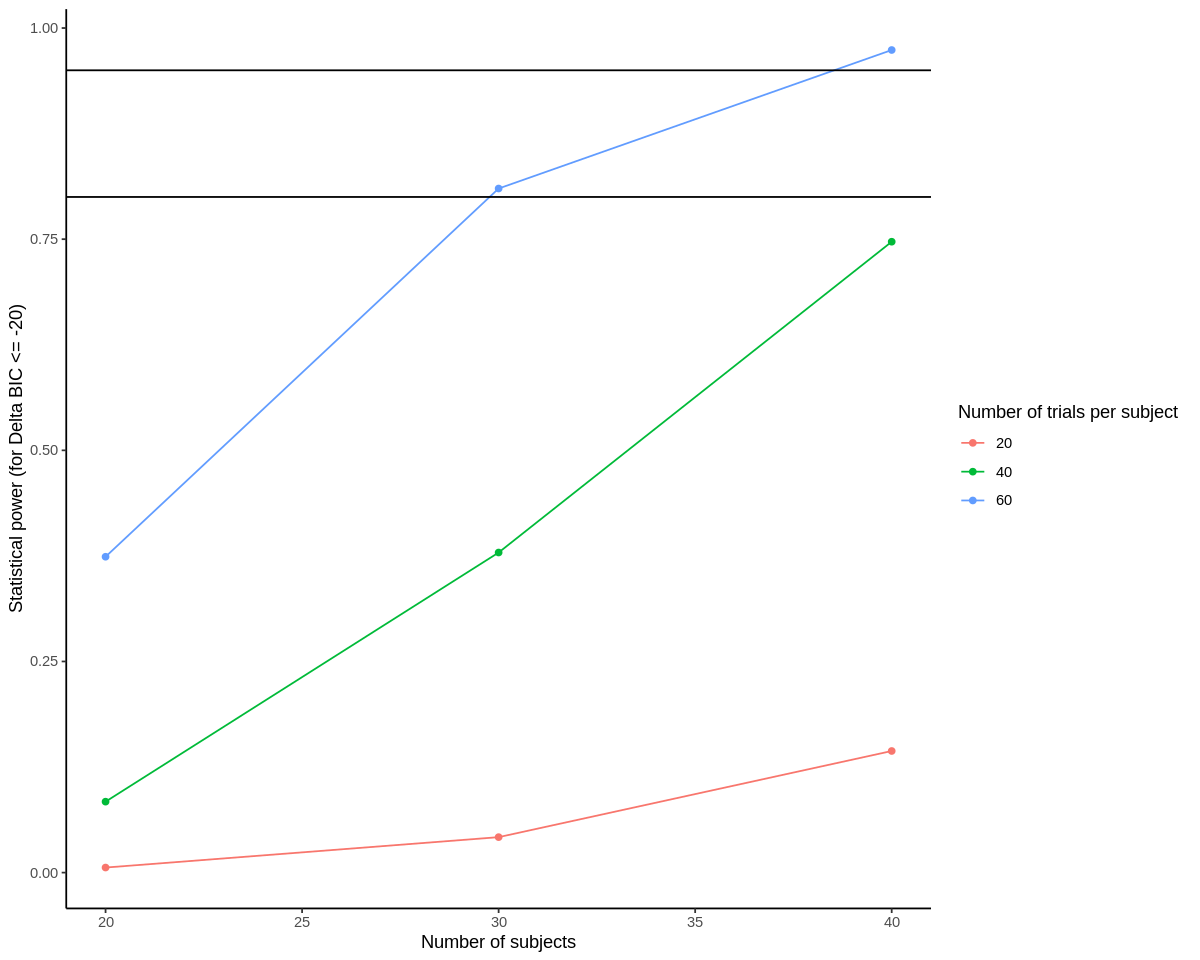

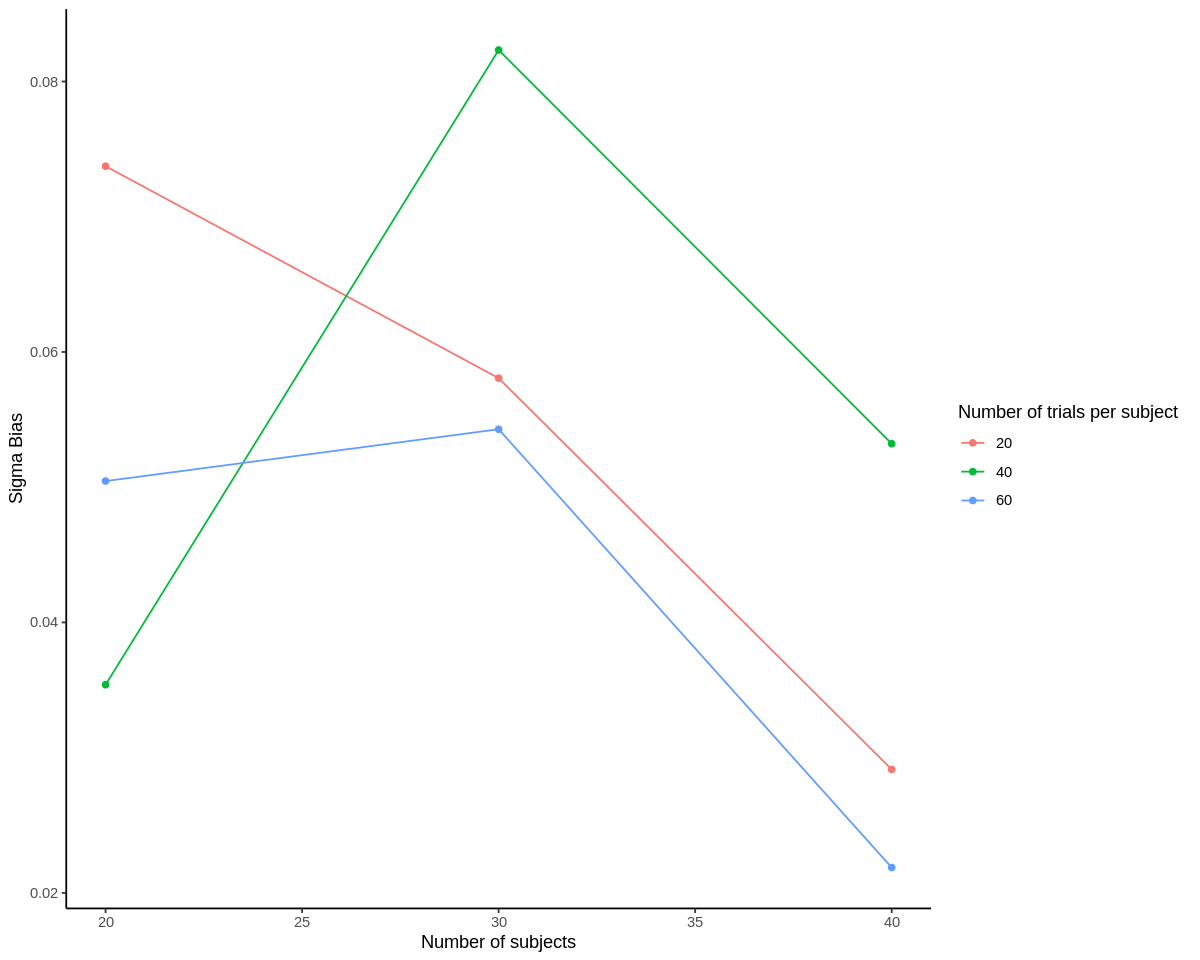

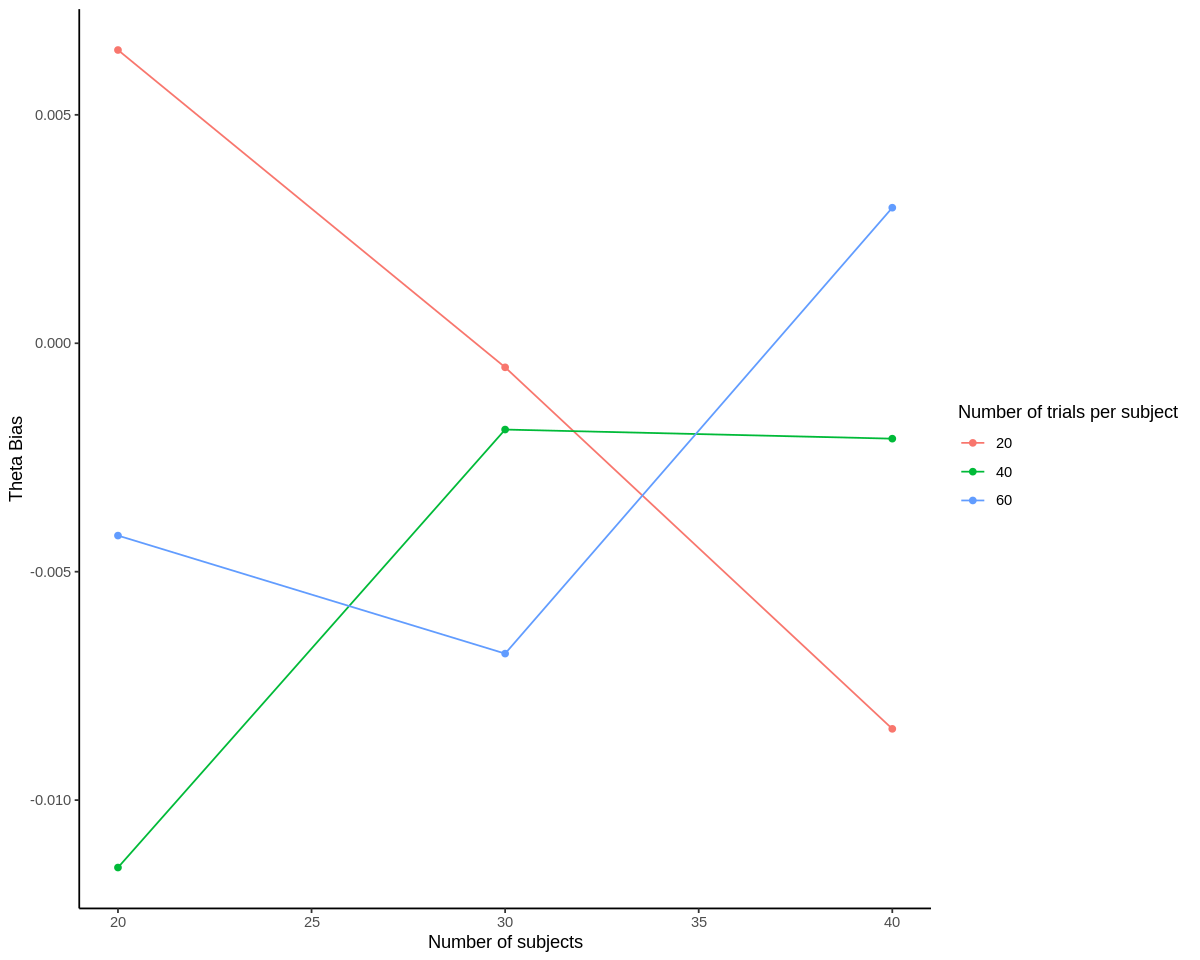

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(results, aes(n_subjects, power, color=as.factor(n_trials), group=n_trials)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) + # again, thresholds for acceptable power
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('Number of trials per subject') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Statistical power (for Delta BIC <= -20)') +
    theme_classic()


ggplot(results, aes(n_subjects, sigma_bias, color=as.factor(n_trials), group=n_trials)) +
    geom_point() +
    geom_line() +
    scale_color_discrete('Number of trials per subject') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Sigma Bias') +
    theme_classic()

ggplot(results, aes(n_subjects, theta_bias, color=as.factor(n_trials), group=n_trials)) +
    geom_point() +
    geom_line() +
    scale_color_discrete('Number of trials per subject') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Theta Bias') +
    theme_classic()

The first plot above shows the percentage of simulations for each combination of number of subjects and number of trials that passed our criterion for a significant model (using BIC instead of p-value in this case). So, you can see that power is a function of both the number of subjects and the number of trials per subject. 

Neither of the bias estimates show a clear trend with respect to number of subjects. We'd expect this for `theta_bias`, but `sigma_bias` typically does go down with more trials as discussed above. The lack of an effect may be because there were only a thousand of each set of simulations. However, we can see that all of the `theta_bias` terms for sufficiently powered subject-trial combinations are between -0.008 and 0.005, which seems acceptably close to 0. `sigma_bias` is much more positive for 30 subjects, 60 trials than for 40 subjects, 60 trials, meaning that the model estimates of variance are more inflated relative to actual variance in this case. But again, we may need to increase the number of simulations per subject-trial combination to make these bias estimates more interpretable. 

Our main takeaway from this analysis would be that 30 subjects, with 60 trials per subject may be sufficiently powered (>80%), but using closer to 40 subjects may yield a more accurate model. 

#### But what is more important, number of subjects or number of trials?

This depends on the relative sizes of the $\sigma_{trial}$ and $\sigma_{slope}$, i.e., how much observations vary from trial to trial, and how much the true effect varies from subject to subject. If the variability associated wtih the $\sigma_{slope}$ is relatively large, adding more subjects will be more important for estimating the population level difference, because it will improve its estimation more than adding more trials. If, however, people are more homogeneous, and respond similarly to the manipulation, then adding more trials would be more efficient. To test this out, you can run the above simulation for different values of $\sigma_{trial}$ and $\sigma_{slope}$, and see it for yourself.

*Notebook authored by Ven Popov. Edited by Krista Bond, Charles Wu, and Patience Stevens.*